In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
from scipy import stats, signal
from scipy.signal import hilbert
from numpy.lib.recfunctions import append_fields, merge_arrays
from scipy.stats import circmean
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.font_manager as fm

import sys
import pickle
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.linear_model import LinearRegression as LR
import matplotlib.colors as clrs
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pylab as pyl
from scipy.spatial.distance import pdist, squareform
from scipy.io import loadmat
import warnings; warnings.simplefilter('ignore')

In [4]:
with open('/home1/anup.das/UP021_vf_pres.pkl', 'rb') as f:
    vf_pres = pickle.load(f)
with open('/home1/anup.das/UP021_xyz_grid.pkl', 'rb') as f:
    xyz_grid = pickle.load(f)
with open('/home1/anup.das/UP021_init_mat.pkl', 'rb') as f:
    init_mat = pickle.load(f)
with open('/home1/anup.das/UP021_letter_list.pkl', 'rb') as f:
    letter_list = pickle.load(f)
with open('/home1/anup.das/UP021_items_upper_unique.pkl', 'rb') as f:
    items_upper_unique = pickle.load(f)
with open('/home1/anup.das/UP021_xg.pkl', 'rb') as f:
    xg = pickle.load(f)
with open('/home1/anup.das/UP021_yg.pkl', 'rb') as f:
    yg = pickle.load(f)

In [5]:
#ICA
from __future__ import division
import pdb,os,time,warnings
import numpy as np
from math import log
from numpy.linalg import *
from numpy.random import rand

vf = vf_pres
vf = np.array(vf)
nt, nr, nc = np.shape(vf)
vf_1 = np.reshape(vf, (nt, nr*nc)).T


vf_all = vf_1
nt = np.shape(vf_all)[1]


def abs_sqr(W,X):
    return abs(W.conj().T.dot(X))**2

X=vf_all
epsilon=.0000001
algorithm='deflation'
max_iter=100
tol=1e-12
whiten=False
w_init=None
n_components=None

n,m  = X.shape

if n_components!=None:
    n = n_components

if whiten:
    X-=X.mean(1,keepdims=True)
    Ux,Sx = eig(np.cov(X))
    K     = np.sqrt(inv(np.diag(Ux))).dot(Sx.conj().T)[:n]
    X     = K.dot(X)
    del Ux,Sx
else:
    K = None

EG = np.ones((n,max_iter))*np.nan

if algorithm=='deflation':

    W = np.zeros((n,n),dtype=np.complex)

    for k in range(n):
        if w_init!=None:
        #if w_init.any():
            w = w_init[:,k]
        else:
            #np.random.seed(k)
            #w = np.random.rand(n,1)+1j*np.random.rand(n,1)
            w = (np.real(init_mat[:,k])+1j*np.imag(init_mat[:,k])).reshape((n,1))

        w/=norm(w)

        n_iter  = 0

        for i in range(max_iter):

            wold = np.copy(w)

            #derivative of the contrast function
            g  =  1/(epsilon+abs_sqr(w,X))
            #derivative of g
            dg = -1/(epsilon+abs_sqr(w,X))**2

            w  = (X * (w.conj().T.dot(X)).conj() * g).mean(1).reshape((n,1))-\
                 (g + abs_sqr(w,X) * dg).mean() * w

            del g,dg

            w/=norm(w)

            # Decorrelation
            w-=W.dot(W.conj().T).dot(w)
            w/=norm(w)

            EG[k,n_iter] = (np.log(epsilon+abs_sqr(w,X))).mean()

            n_iter+=1

            lim = (abs(abs(wold)-abs(w))).sum()
            if lim<tol:
                break

        if n_iter==max_iter and lim>tol:
            warnings.warn('FastICA did not converge. Consider increasing '
                          'tolerance or the maximum number of iterations.')

        W[:,k] = w.ravel()
        
Shat = W.conj().T.dot(X)

#calculate energy percentage
ic_vars = np.mean(np.abs(Shat**2), axis = 1)
ic_vars_per = ic_vars*100/np.sum(ic_vars)

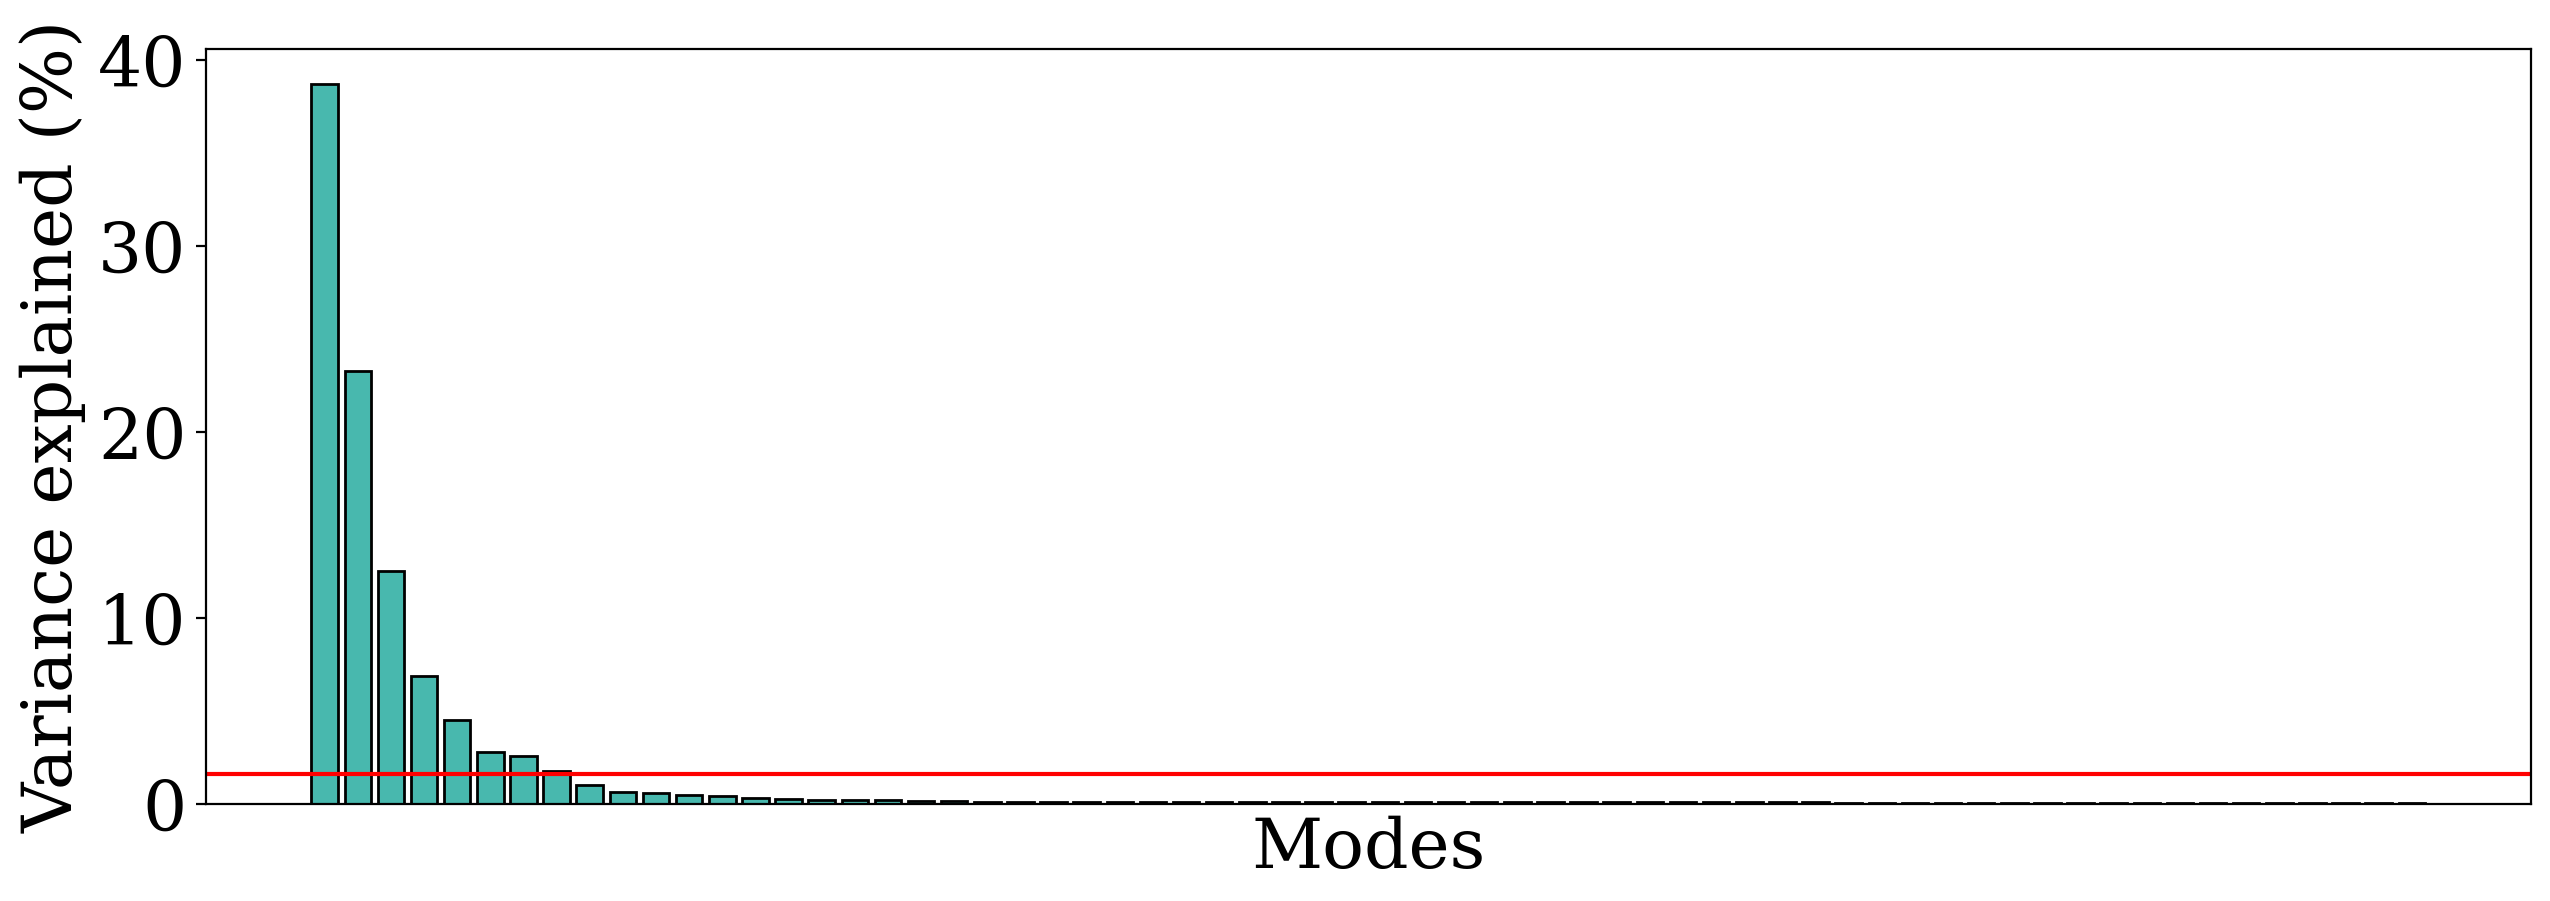

In [6]:
#plot variance explained for all modes

ic_vars_per_sorted = ic_vars_per[np.argsort(ic_vars_per)[::-1]]
    
fig = plt.figure(figsize=(15,5), dpi= 200) 

plt.rcParams['font.family'] = ['DejaVu Serif']
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams.update({'font.size': 25})

for i_comp in range(0, len(ic_vars_per_sorted), 1):
    
    plt.bar([str(i_comp+1)], 
            [ic_vars_per_sorted[i_comp]], color = '#48b8ae', edgecolor='black', capsize=10)

var_thres = 100/np.shape(vf_all)[0]
plt.axhline(y = var_thres, color = 'r')
plt.ylabel('Variance explained (%)')
plt.xlabel('Modes')
plt.xticks([])
plt.show()

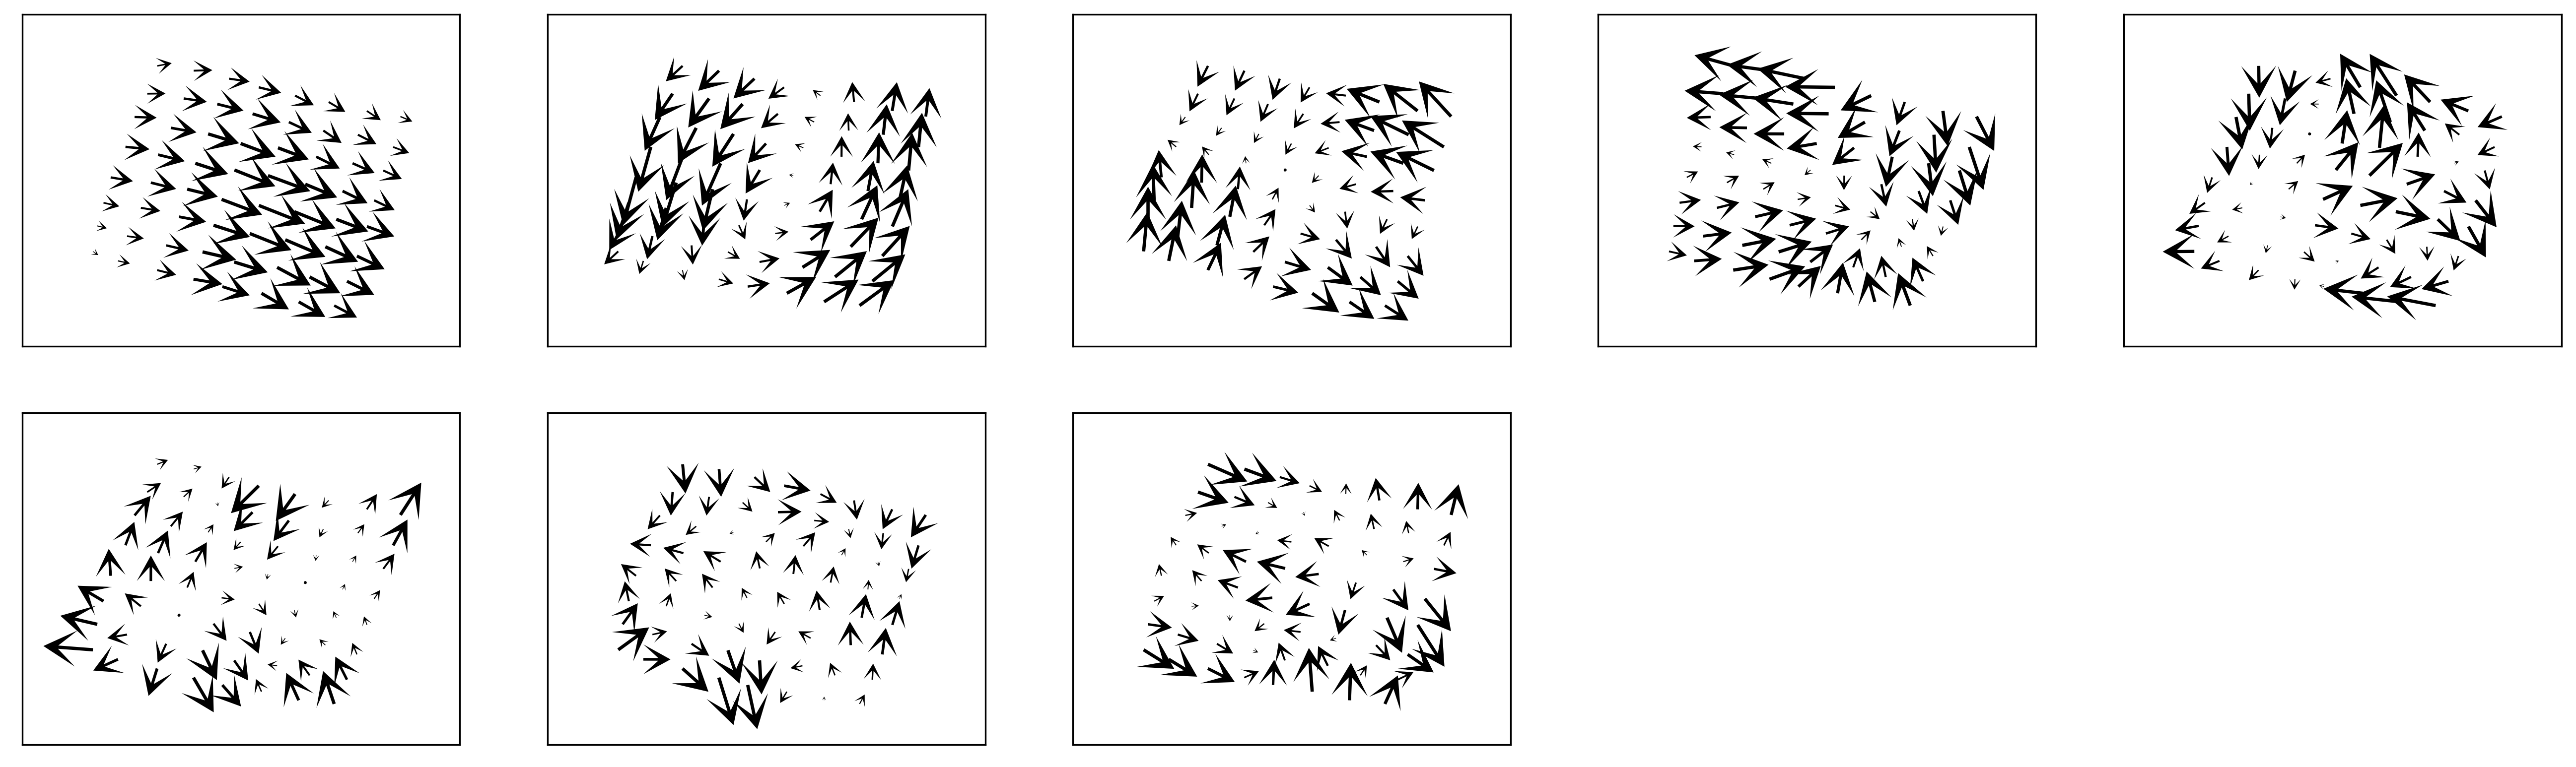

In [12]:
#Plot the directions corresponding to the modes
%matplotlib inline

W_sorted = W[:, np.argsort(ic_vars_per)[::-1]]
Shat_sorted = Shat[np.argsort(ic_vars_per)[::-1], :]
ic_vars_per_sorted = ic_vars_per[np.argsort(ic_vars_per)[::-1]]
w_all = Shat_sorted
var_thres = 100/np.shape(vf_all)[0]
n_modes = len(np.argwhere(ic_vars_per_sorted > var_thres))

fig_columns = 5
fig_rows = int(np.ceil(n_modes/fig_columns))

fig = plt.figure(figsize=(22,6.5), dpi= 300) 

count = 0
for i_mode in range(0, n_modes, 1):
    
    scale = 3
          
    mode_reshaped_ica = np.reshape(W_sorted[:, i_mode], (nr, nc))
    F1g = np.real(np.mean(w_all[i_mode, :]) * mode_reshaped_ica)
    F2g = np.imag(np.mean(w_all[i_mode, :]) * mode_reshaped_ica)   
    
    F11g = F1g/np.max(np.sqrt(F1g**2 + F2g**2))
    F22g = F2g/np.max(np.sqrt(F1g**2 + F2g**2))
    
    count+=1
    fig.add_subplot(fig_rows, fig_columns, count)
    plt.quiver(xg,yg,F11g,F22g, scale=scale, scale_units='inches', headwidth = 11, headlength = 10)
    plt.xlim([-60, 65])
    plt.ylim([-80, 35])
    plt.xticks([])
    plt.yticks([])
        
plt.show()